##### Copyright 2024 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Multimodal Chatbot using Google Gemini API


<a href="https://colab.research.google.com/github/Bhavesh2k4/cookbook/blob/Added-Text-Image-Multimodal-Bot-549/quickstarts/Gemini_Multimodal_Text_Image_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
This notebook walks through the process of creating a multimodal chatbot using Google's Gemini API. The chatbot can:
- Process text inputs
- Analyze images
- Handle combined text and image inputs (multimodal prompts)
- Maintain conversation history for contextual responses
- Format and present responses with markdown support

## Prerequisites
- Google API key for Gemini
- Python 3.9+
- Required libraries: google-generativeai, pillow, IPython, pandas, matplotlib

In [2]:
# Environment Setup
!pip install google-generativeai pillow IPython pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.3 MB/s eta 0:00:00


In [19]:
# Import Libraries
import os
import time
import base64
from typing import List, Dict, Tuple, Optional, Union
from io import BytesIO
from IPython.display import display, Markdown, Image
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import google.generativeai as genai
from google.generativeai import types
from google.generativeai.types import HarmCategory, HarmBlockThreshold


## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](../quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

## Available Gemini Models

Function to List and Display all Gemini Models

In [5]:
# Function to list available models
def list_available_models():
    """Display information about available Gemini models."""
    models = genai.list_models()
    model_info = []

    for model in models:
        if 'gemini' in model.name.lower():
            supported_features = []
            if hasattr(model, 'supported_generation_methods'):
                supported_features = model.supported_generation_methods

            model_info.append({
                'Name': model.name,
                'Description': model.description,
                'Input Limit': model.input_token_limit if hasattr(model, 'input_token_limit') else 'Unknown',
                'Output Limit': model.output_token_limit if hasattr(model, 'output_token_limit') else 'Unknown',
                'Features': supported_features
            })

    return pd.DataFrame(model_info)

# Display available models
display(Markdown("### Available Gemini Models"))
models_df = list_available_models()
display(models_df)

### Available Gemini Models

,Name,Description,Input Limit,Output Limit,Features
0,models/gemini-1.0-pro-vision-latest,The original Gemini 1.0 Pro Vision model versi...,12288,4096,"[generateContent, countTokens]"
1,models/gemini-pro-vision,The original Gemini 1.0 Pro Vision model versi...,12288,4096,"[generateContent, countTokens]"
2,models/gemini-1.5-pro-latest,Alias that points to the most recent productio...,2000000,8192,"[generateContent, countTokens]"
3,models/gemini-1.5-pro-001,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens, createCachedCon..."
4,models/gemini-1.5-pro-002,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens, createCachedCon..."
5,models/gemini-1.5-pro,"Stable version of Gemini 1.5 Pro, our mid-size...",2000000,8192,"[generateContent, countTokens]"
6,models/gemini-1.5-flash-latest,Alias that points to the most recent productio...,1000000,8192,"[generateContent, countTokens]"
7,models/gemini-1.5-flash-001,"Stable version of Gemini 1.5 Flash, our fast a...",1000000,8192,"[generateContent, countTokens, createCachedCon..."
8,models/gemini-1.5-flash-001-tuning,Version of Gemini 1.5 Flash that supports tuni...,16384,8192,"[generateContent, countTokens, createTunedModel]"
9,models/gemini-1.5-flash,Alias that points to the most recent stable ve...,1000000,8192,"[generateContent, countTokens]"


## Choose the Model

In [6]:
DEFAULT_MODEL_NAME="gemini-2.0-flash" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

#For Better Performance - You can choose Gemini Pro (Make Note of Rate Limits)

## Image Processing Utilities
These functions help prepare and process images for the Gemini model.

In [31]:
def load_image_from_path(image_path: str) -> PILImage.Image:
    """
    Load an image from a file path.

    Args:
        image_path: Path to the image file

    Returns:
        PIL Image object
    """
    try:
        image = PILImage.open(image_path)
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def load_image_from_url(image_url: str) -> PILImage.Image:
    """
    Load an image from a URL.

    Args:
        image_url: URL of the image

    Returns:
        PIL Image object
    """
    try:
        import requests
        response = requests.get(image_url)
        image = PILImage.open(BytesIO(response.content))
        return image
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None

def resize_image(image: PILImage.Image, max_size: int = 1024) -> PILImage.Image:
    """
    Resize an image while maintaining aspect ratio to ensure it's under
    the size limits for the API.

    Args:
        image: PIL Image object
        max_size: Maximum dimension (width or height)

    Returns:
        Resized PIL Image object
    """
    width, height = image.size

    if max(width, height) > max_size:
        if width > height:
            new_width = max_size
            new_height = int(height * max_size / width)
        else:
            new_height = max_size
            new_width = int(width * max_size / height)

        return image.resize((new_width, new_height))

    return image

def display_image(image: PILImage.Image, width: int = 400):
    """
    Display an image with specified width in the notebook.

    Args:
        image: PIL Image object
        width: Display width
    """
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    image_data = buffer.getvalue()

    display(Image(data=image_data, width=width))

## ChatBot Class Definition
This class encapsulates our chatbot functionality, including handling text and image inputs,
maintaining conversation history, and processing responses.

In [34]:
class GeminiMultimodalChatBot:
    """
    A chatbot that can process both text and images using Google's Gemini models.

    Attributes:
        model_name: Name of the Gemini model to use
        temperature: Controls randomness in responses (0.0 to 1.0)
        max_tokens: Maximum number of tokens in the response
        top_p: Controls diversity via nucleus sampling
        top_k: Controls diversity via top-k sampling
        conversation: The Gemini conversation object that maintains history
    """

    ''' Temperature set to 0.7 to balance creativity and accuracy in multimodal responses.
        Lower values (0.1-0.3) produce more deterministic outputs but may be too rigid for natural
        image descriptions, while higher values (0.8-1.0) increase creativity but risk less accurate
        interpretations of visual content. 0.7 provides optimal balance for conversational AI
        handling both text and images.'''

    def __init__(
        self,
        model_name: str = DEFAULT_MODEL_NAME,
        temperature: float = 0.7,
        max_tokens: int = 2048,
        top_p: float = 0.95,
        top_k: int = 40,
        system_prompt: str = None
    ):
        """
        Initialize the chatbot with configuration parameters.

        Args:
            model_name: Name of the Gemini model to use
            temperature: Controls randomness (higher = more random)
            max_tokens: Maximum output length
            top_p: Controls diversity via nucleus sampling
            top_k: Controls diversity via top-k sampling
            system_prompt: Initial instructions for the model
        """
        self.model_name = model_name
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.top_p = top_p
        self.top_k = top_k
        self.system_prompt = system_prompt

        # Initialize the model with generation config
        generation_config = {
            "temperature": self.temperature,
            "max_output_tokens": self.max_tokens,
            "top_p": self.top_p,
            "top_k": self.top_k
        }

        # Initialize the model with system instructions if provided
        if system_prompt:
            self.model = genai.GenerativeModel(
                model_name=self.model_name,
                generation_config=generation_config,
                system_instruction=system_prompt
            )
        else:
            self.model = genai.GenerativeModel(
                model_name=self.model_name,
                generation_config=generation_config
            )

        # Start a new conversation
        self.reset_conversation()

    def reset_conversation(self):
        """
        Reset the conversation history.
        """
        self.conversation = self.model.start_chat(history=[])

    def send_message(self,
                    text: str = None,
                    image: PILImage.Image = None,
                    stream: bool = False) -> str:
        """
        Send a message to the chatbot with optional image.

        Args:
            text: Text prompt to send
            image: Optional image to include
            stream: Whether to stream the response

        Returns:
            Response from the model
        """
        # Create the content parts
        content_parts = []

        # Add text if provided
        if text:
            content_parts.append(text)

        # Add image if provided
        if image:
            content_parts.append(image)

        # Ensure you have at least one content part
        if not content_parts:
            raise ValueError("Must provide at least text or image")

        try:
            # Send the message to the model
            if stream:
                response = self.conversation.send_message(content_parts, stream=True)

                # Process streamed response
                full_response = ""
                for chunk in response:
                    if hasattr(chunk, 'text'):
                        print(chunk.text, end="", flush=True)
                        full_response += chunk.text
                print()  # New line after streaming completes
                return full_response
            else:
                response = self.conversation.send_message(content_parts)
                return response.text

        except Exception as e:
            error_msg = f"Error communicating with Gemini API: {str(e)}"
            print(error_msg)
            return error_msg

    def get_conversation_history(self):
        """
        Get the current conversation history.

        Returns:
            List of conversation turns
        """
        return self.conversation.history

    def display_conversation(self):
        """Display the conversation history in a readable format."""
        history = self.get_conversation_history()

        for entry in history:
            # Skip the system prompt exchange if desired
            if hasattr(entry, 'role'):
                role = entry.role

                if role == "user":
                    display(Markdown("### 👤 User:"))

                    for part in entry.parts:
                        if hasattr(part, 'text'):
                            display(Markdown(part.text))
                        elif hasattr(part, 'inline_data') and part.inline_data:
                            display(Markdown("*[Image input]*"))

                elif role == "model":
                    display(Markdown("### 🤖 Gemini:"))

                    for part in entry.parts:
                        if hasattr(part, 'text'):
                            display(Markdown(part.text))

## Initialize the ChatBot
Let's create our chatbot instance with some custom parameters.

In [35]:
# Define a system prompt to guide the model's behavior
system_prompt = """
  You are a helpful, friendly assistant. When responding to questions:
  - If you're unsure, be honest about your limitations
  - Provide detailed and accurate information
  - For image analysis, describe what you see in detail
  - Use markdown formatting to make responses easy to read
  - When discussing code, include well-commented examples
"""

# Initialize the chatbot
chatbot = GeminiMultimodalChatBot(
    temperature=0.7,
    max_tokens=4096,
    system_prompt=system_prompt
)

''' Temperature set to 0.7 to balance creativity and accuracy in multimodal responses.
    Lower values (0.1-0.3) produce more deterministic outputs but may be too rigid for natural
    image descriptions, while higher values (0.8-1.0) increase creativity but risk less accurate
    interpretations of visual content. 0.7 provides optimal balance for conversational AI
    handling both text and images.'''

print("✅ Multimodal chatbot initialized successfully!")

✅ Multimodal chatbot initialized successfully!


## Text-Only Interaction Example
Let's start with a simple text-only example to test our chatbot:

In [36]:
# Example text query
text_query = "Explain how transformer models work in machine learning in 4 simple steps."

print("Sending text query to Gemini...\n")
response = chatbot.send_message(text_query)
display(Markdown("### Response:"))
display(Markdown(response))

Sending text query to Gemini...



### Response:

Okay, here's a simplified explanation of how Transformer models work, broken down into four key steps:

**1. Input Embedding and Positional Encoding:**

*   **Embedding:** The input text is first broken down into individual words or sub-words (tokens). Each token is then converted into a vector representation called an embedding.  These embeddings capture the semantic meaning of the words.  Think of it as turning words into numerical representations that the model can understand.
*   **Positional Encoding:** Transformers, unlike recurrent neural networks, don't inherently understand the order of words in a sequence.  Positional encoding adds information about the position of each word in the sentence to the embedding vectors. This helps the model understand the sequence's structure.

**2. Self-Attention:**

*   This is the heart of the Transformer.  Self-attention allows the model to weigh the importance of different words in the input sequence when processing a specific word.
*   For each word, the model calculates three vectors:
    *   **Query (Q):** Represents what the word is looking for.
    *   **Key (K):** Represents what other words offer.
    *   **Value (V):** Represents the actual information contained in the word.
*   The model calculates an attention score between the query of a word and the keys of all other words.  These scores determine how much attention should be paid to each word.
*   The attention scores are then used to weight the value vectors.  Words that are highly relevant to the current word will have a larger weight.
*   The weighted value vectors are summed to produce the self-attention output for that word. This output captures the context of the word within the entire sequence.
*   This process is done in parallel for all words in the input sequence.
*   **Multi-Head Attention:** To capture different aspects of the relationships between words, the self-attention mechanism is often repeated multiple times in parallel, each with its own set of learned parameters. This is called multi-head attention. The outputs of the different heads are then concatenated and transformed to produce the final self-attention output.

**3. Feed-Forward Neural Network:**

*   The output of the self-attention layer (or multi-head attention layer) is then passed through a feed-forward neural network.  This network is applied to each word independently.
*   It typically consists of two fully connected layers with a non-linear activation function in between. This adds non-linearity to the model and allows it to learn more complex relationships between words.

**4. Decoder (for sequence generation):**

*   If the Transformer is used for sequence generation tasks (like translation or text summarization), it includes a decoder component.
*   The decoder receives the output from the encoder (which has processed the input sequence) and generates the output sequence one word at a time.
*   The decoder also uses self-attention to attend to the previously generated words in the output sequence.  This helps maintain consistency and coherence in the generated text.
*   **Encoder-Decoder Attention:**  The decoder uses attention to focus on the relevant parts of the encoded input sequence. This allows the decoder to condition its output on the input sequence.
*   The decoder repeats this process until it generates a special "end-of-sequence" token, indicating that the output sequence is complete.

**In Summary:**

1.  **Input:** Convert words to numbers and add positional information.
2.  **Self-Attention:**  Let each word consider all other words to understand context.
3.  **Feed-Forward Network:** Process each word individually to add complexity.
4.  **Decoder (if needed):** Generate the output sequence, one word at a time, using attention over both the input and the previously generated output.

Let me know if you'd like a deeper dive into any of these steps!


## Image Analysis Example
Now let's test the chatbot's ability to analyze an image:


### Test Image:

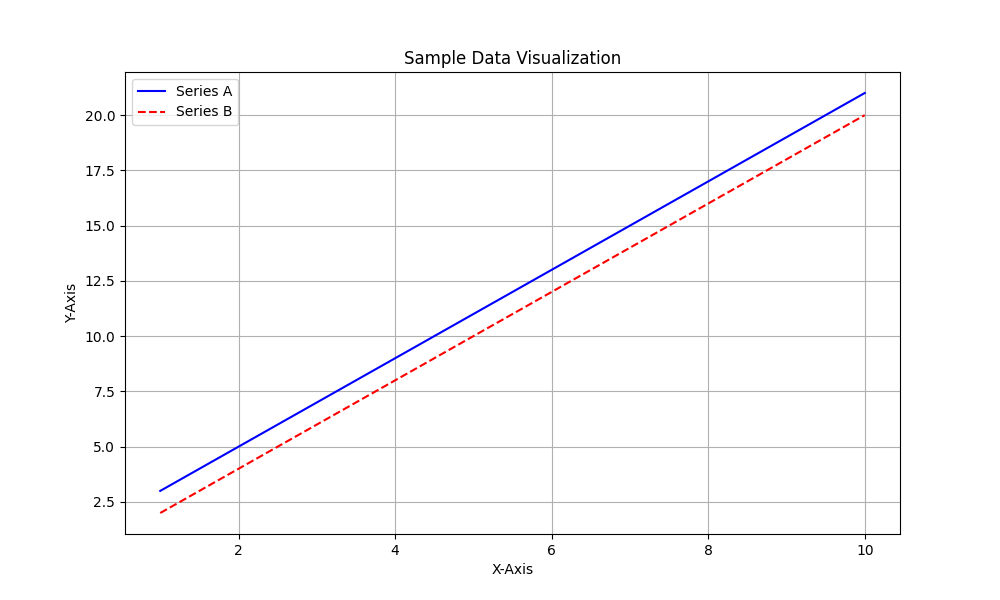


Sending image for analysis...



### Response:

Okay, here's a detailed analysis of the chart:

**Overall Description:**

The image shows a line graph titled "Sample Data Visualization."  The graph plots two series of data, labeled "Series A" and "Series B," against an X-axis and a Y-axis. Both series appear to have a positive linear relationship, meaning that as the X-axis value increases, the Y-axis value also increases. The graph has a grid background to aid in reading the values.

**Axes:**

*   **X-Axis:** The X-axis is labeled "X-Axis" and ranges from 1 to 10.
*   **Y-Axis:** The Y-axis is labeled "Y-Axis" and ranges from approximately 2.5 to 20.

**Data Series:**

*   **Series A:** Represented by a solid blue line.  It starts at approximately Y = 3 when X = 1 and increases linearly to approximately Y = 21 when X = 10.
*   **Series B:** Represented by a dashed red line.  It starts at approximately Y = 2.5 when X = 1 and increases linearly to approximately Y = 20 when X = 10.

**Key Observations:**

*   Both series show a positive correlation between the X and Y values.
*   Series A consistently has a higher Y value than Series B for any given X value.  This means that Series A is always "above" Series B on the graph.
*   The slopes of the two lines appear to be similar, suggesting that both series increase at roughly the same rate, but Series A has a higher starting point.
*   Both Series A and Series B can be approximated using a linear equation of the form y = mx + c, where m is the slope and c is the y-intercept.

**In summary, the chart visually compares two sets of data that exhibit a positive linear trend, with Series A consistently having higher values than Series B across the range of X-axis values shown.**


In [37]:
# Function to create a sample test image
def create_test_plot():
    """Create a sample plot for testing image analysis."""
    plt.figure(figsize=(10, 6))

    # Create some sample data
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    y1 = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
    y2 = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

    # Plot the data
    plt.plot(x, y1, 'b-', label='Series A')
    plt.plot(x, y2, 'r--', label='Series B')

    # Add labels and title
    plt.xlabel('X-Axis')
    plt.ylabel('Y-Axis')
    plt.title('Sample Data Visualization')
    plt.legend()
    plt.grid(True)

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    # Convert to PIL Image
    test_image = PILImage.open(buf)
    plt.close()

    return test_image

# Create a test image
test_image = create_test_plot()

# Display the image
display(Markdown("### Test Image:"))
display_image(test_image)

# Ask the chatbot to analyze the image
image_query = "What does this image show? Please analyze this chart in detail."

print("\nSending image for analysis...\n")
response = chatbot.send_message(image_query, test_image)
display(Markdown("### Response:"))
display(Markdown(response))

## Multimodal Prompting
### Combined Text and Image (Multimodal) Example
Now let's test the chatbot with a combined text and image input:

In [38]:
# Create a multimodal prompt
multimodal_query = "Based on the trends shown in this chart, what might be a reasonable prediction for the next three data points in Series A? Explain your reasoning."

print("Sending multimodal query (text + image)...\n")
response = chatbot.send_message(multimodal_query, test_image)
display(Markdown("### Response:"))
display(Markdown(response))

Sending multimodal query (text + image)...



### Response:

Okay, here's how we can predict the next three data points for Series A, along with the reasoning:

**Reasoning:**

Since Series A shows a clear linear trend, we can estimate the slope of the line and use that to extrapolate the next data points.  Visually, for every one unit increase in the X-axis, the Y-axis increases by approximately 2 units. A more precise calculation using the endpoints (1, 3) and (10, 21) can be done:

Slope (m) = (Change in Y) / (Change in X) = (21 - 3) / (10 - 1) = 18 / 9 = 2

So, the slope is 2.

**Predictions:**

Assuming the linear trend continues:

*   **X = 11:**  Y ≈ 21 + 2 = 23
*   **X = 12:**  Y ≈ 23 + 2 = 25
*   **X = 13:**  Y ≈ 25 + 2 = 27

**Therefore, a reasonable prediction for the next three data points in Series A would be approximately (11, 23), (12, 25), and (13, 27).**

**Important Considerations:**

*   **Linearity Assumption:** This prediction relies heavily on the assumption that the linear trend continues beyond the currently visible data. If the underlying process generating the data changes, the actual values could deviate significantly.
*   **Real-World Data:** In real-world scenarios, data rarely follows a perfectly linear path. There's usually some noise or variation. These predictions are best considered estimates.
*   **More Sophisticated Methods:** For more accurate predictions, especially with non-linear data, you might use techniques like regression analysis or time series forecasting.


## Advanced Feature: Response Streaming
Let's demonstrate how to stream responses from the model in real-time:

In [39]:
display(Markdown("### Streaming Example"))
print("Sending query with streaming enabled...\n")

streaming_query = "Write a short paragraph explaining how neural networks learn from data."
print("Response (streaming):")
chatbot.send_message(streaming_query, stream=True)

### Streaming Example

Sending query with streaming enabled...

Response (streaming):
Neural networks learn from data through a process of iterative adjustment. Initially, the network's connections (weights) are assigned random values. As data is fed into the network, it produces an output, which is then compared to the desired output. The difference between the predicted and actual output, known as the loss, is used to adjust the weights in the network. This adjustment is typically done using an optimization algorithm like gradient descent, which iteratively modifies the weights to minimize the loss. By repeatedly processing data and adjusting its weights, the network gradually learns to map inputs to the desired outputs, effectively learning the underlying patterns in the data.



"Neural networks learn from data through a process of iterative adjustment. Initially, the network's connections (weights) are assigned random values. As data is fed into the network, it produces an output, which is then compared to the desired output. The difference between the predicted and actual output, known as the loss, is used to adjust the weights in the network. This adjustment is typically done using an optimization algorithm like gradient descent, which iteratively modifies the weights to minimize the loss. By repeatedly processing data and adjusting its weights, the network gradually learns to map inputs to the desired outputs, effectively learning the underlying patterns in the data.\n"

## Interactive function for user testing

In [40]:
def process_user_query(text_input=None, image_path=None):
    """
    Process a user query with optional image.

    Args:
        text_input: User's text query
        image_path: Path to an image file (optional)
    """
    image = None
    if image_path:
        image = load_image_from_path(image_path)
        if image:
            image = resize_image(image)
            display(Markdown("### Input Image:"))
            display_image(image)

    display(Markdown(f"### Query: {text_input}"))
    response = chatbot.send_message(text=text_input, image=image)
    display(Markdown("### Response:"))
    display(Markdown(response))

#example:
#process_user_query("What's in this image?", "/content/earth.jpg")
#uncomment to run
# format ( text , path to image)


## Customizing the ChatBot Parameters
You can adjust various parameters to change how the chatbot behaves:

In [41]:
# Function to create a new chatbot with custom
''' Temperature set to 0.7 to balance creativity and accuracy in multimodal responses.
        Lower values (0.1-0.3) produce more deterministic outputs but may be too rigid for natural
        image descriptions, while higher values (0.8-1.0) increase creativity but risk less accurate
        interpretations of visual content. 0.7 provides optimal balance for conversational AI
        handling both text and images.'''

def create_custom_chatbot(
    temperature=0.7,
    max_tokens=2048,
    system_prompt="You are a helpful assistant that provides detailed, accurate information."
):
    """
    Create a new chatbot with custom parameters.

    Args:
        temperature: Controls randomness (0.0-1.0)
        max_tokens: Maximum response length
        system_prompt: Initial instructions

    Returns:
        Configured chatbot instance
    """
    return GeminiMultimodalChatBot(
        temperature=temperature,
        max_tokens=max_tokens,
        system_prompt=system_prompt
    )

# Example of creating a more creative chatbot
creative_bot = create_custom_chatbot(
    temperature=0.9,  # Higher temperature for more creative responses
    max_tokens=4096,
    system_prompt="You are a highly creative assistant. Provide imaginative, detailed responses that explore interesting possibilities."
)

# Example of creating a more precise, factual chatbot
precise_bot = create_custom_chatbot(
    temperature=0.1,  # Lower temperature for more deterministic responses
    max_tokens=2048,
    system_prompt="You are a precise, factual assistant. Provide concise, accurate information with minimal speculation."
)

## Error Handling and Rate Limiting
In production applications, you'll want robust error handling and rate limiting.

In [42]:
def send_message_with_retry(
    chatbot: GeminiMultimodalChatBot,
    text: str = None,
    image: PILImage.Image = None,
    max_retries: int = 3,
    retry_delay: int = 2
):
    """
    Send a message with automatic retry for handling rate limits or transient errors.

    Args:
        chatbot: GeminiMultimodalChatBot instance
        text: Text prompt
        image: Image prompt (optional)
        max_retries: Maximum number of retry attempts
        retry_delay: Seconds to wait between retries

    Returns:
        Model response or error message
    """
    retries = 0

    while retries <= max_retries:
        try:
            response = chatbot.send_message(text=text, image=image)
            return response

        except Exception as e:
            error_message = str(e).lower()

            # Handle rate limiting
            if "rate limit" in error_message or "quota" in error_message:
                retries += 1
                if retries <= max_retries:
                    wait_time = retry_delay * retries
                    print(f"Rate limit reached. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    return f"Error: Maximum retries reached due to rate limiting. Please try again later."

            # Handle other errors
            else:
                return f"Error communicating with Gemini API: {str(e)}"

    return "Failed to get response after multiple attempts."

## Conclusion and Next Steps

You've successfully built a multimodal chatbot using Google's Gemini API that can:
- Process text inputs
- Analyze and interpret images for visual understanding
- Handle combined text and image inputs for rich multimodal conversations
- Maintain ongoing conversation history
- Stream responses in real-time for a dynamic user experience

Remember that responsible AI use is critical — ensure your chatbot adheres to ethical guidelines, respects user privacy, and clearly communicates capabilities and limitations to users.

---

### 📚 Useful API References

- [**Text Generation**](https://ai.google.dev/gemini-api/docs/text-generation?lang=python)  
  Learn how to:
  - Generate natural language text from prompts  
  - Use response streaming for real-time interactions  
  - Configure model parameters  

- [**Vision**](https://ai.google.dev/gemini-api/docs/vision)  
  Explore how to:
  - Analyze and understand image content  


---

### 🛠️ Related Examples

- [**Build a chat app with Gemini**](https://ai.google.dev/gemini-api/tutorials/web-app?lang=python)  
  A practical tutorial that walks you through:
  - Setting up a web-based chat interface  
  - Integrating text and image input handling  
  - Streaming model responses with live updates  
  - Maintaining session history with persistent state  

---

### 🚀 Continue Your Discovery of the Gemini API

- [**Get Started with Gemini API**](https://ai.google.dev/gemini-api/docs/quickstart?lang=python)  
  Perfect for beginners to:
  - Set up API credentials and authentication  
  - Make your first API call  
  - Understand core request/response structure  

- Dive deeper with:
  - [Code samples on GitHub](https://github.com/google/generative-ai-docs/tree/main)   
  - Experimentation via [Google AI Studio](https://makersuite.google.com/app)  
